# TO DO

11/25:
Finish setting up CUQ RAPS, integrating k_reg and reg_vec properly.

Add notes to all the functions!

Add all this to Classification (lower priority).


# Notebook Setup and Resources

This notebook is to serve as an overview of *Conformal Uncertainty Quantification* to be used in the final project for MATH 6388: Statistical and Machine Learning at the University of Colorado Denver, Fall 2023.

It will, to begin, contain an summary of the relevant theory/mathematics and examples illustrating the concepts.

This notebook draws heavily from the following resources:

A Tutorial on Conformal Prediction: https://www.youtube.com/watch?v=nql000Lu_iE&list=PLBa0oe-LYIHa68NOJbMxDTMMjT8Is4WkI&index=6

A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification: https://arxiv.org/abs/2107.07511

Conformal prediction under ambiguous ground truth: https://arxiv.org/abs/2307.09302

# Classification

## Problem Statement

In classification, our goal is to develop a model, call it $\hat{f}_y(x)$, which estimates the quantity $\pi_y(x) = \mathbb{P}[Y=y|X=x]$

This could be either a single value in $[0,1]$ for binary classification, or a probability vector over $K$ classes, such that $\pi_y(x) = [p_0,...,p_{K-1}], \sum_{i=0}^{K-1} p_i = 1$

Instead, we would like to have a better idea of what our model thinks about the new data point than a raw probability. We will construct a set $\hat{C}(x_{n+1}) \subseteq \mathcal{Y}$, where $\mathcal{Y}$ is all our possible classes (i.e., $|\mathcal{Y}| = K$), such that $\mathbb{P}[y_{n+1} \in \hat{C}(x_{n+1})] \geq 1-\alpha$.

In words, we are looking for a set of possible classes such that, with some probability $1- \alpha$, the *true* $y$ is in that set. Now, there is an obvious trivial solution, just let $\hat{C}(x_{n+1}) = \mathcal{Y}$, as the true label will be in the set of all labels with 100% probability, but this isn't interesting.

Thus, we will modify our objective to:

$$ \hat{C}(x_{n+1}) \subset \mathcal{Y} $$

Such that:

$$ \mathbb{P}[y_{n+1} \in \hat{C}(x_{n+1})] \geq 1-\alpha $$

We call $\geq 1-\alpha$ the *coverage* and $\alpha$ is the error rate, which has low values, such as 0.1, 0.05, etc.

Of course, this can't be our *only* criteria, because we could get a probability of $1-\alpha$ easily with:

$$ \hat{C} = \begin{cases} 
\mathcal{Y} & \text{with prob} & 1-\alpha \\
\emptyset & \text{with prob} & \alpha 
\end{cases}$$

So, we also want our set $\hat{C}(x_{n+1})$ to be *small* in some sense of the word and *adaptive* so that we get different sets for different inputs $x_{n+1}$.

## Method, the Least Ambiguous set-valued Classifier (LAC)

To begin, we will divide our data $\mathcal{X}$ into three sets, $\mathcal{X}_{train}$, $\mathcal{X}_{calibration}$, and $\mathcal{X}_{test}$. 

The $\mathcal{X}_{train}$ is our standard training set used to train the model $\hat{f}$.

Now, we have to introduce a *score* function, $s(x,y)$ which tells us how well, in some sense, our model is doing. For classification, the obvious choice is the probability of that specific class. As in, if $\hat{f}(x)_y = [p_0, \dots, p_{K-1}]$, we can take:

$$ s(x,y) = 1 - \hat{f}(x)_{y_i} = p_i, \text{i is the true class} $$

Now, why do we want $1 - \hat{f}(x)_{y_i}$? This will become apparent momentarily. It doesn't *really* matter, it just depends how we set everything up. One could take $\hat{f}_(x)_{y_i}$ as the score, but then everything we do below will be opposite. For now, we will stick to a *left* or *negative* formulation, which follows. 

For each element of our calibration set $\mathcal{X}_{cal}$ we repeat the above process, giving us $\{s_1, \dots, s_{n_{cal}} \}$.

From here, we are going to *order* them and find:

$$ \hat{q} = \lceil (1-\alpha)(n_{cal} +1) \rceil \quad \text{smallest of } s_i, i \in \{1, \dots, n_{cal} \}$$

Let's take a moment to write out what exactly this $\hat{q}$ is. It is the value such that at least $1-\alpha$ percent of examples in our calibration set have scores above this value.

We note that the above formulation is just the *quantile*:

$$ \hat{q} = quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) $$

From this, we can construct our $\hat{C}(x_{test})$ as:

$$ \hat{C}(x_{test}) = \{y : s(x_{test}, y_{test}) \leq \hat{q}\} $$

Recalling our definition of $s(x,y)$, we can rewrite this as:

$$ \hat{C}(x_{test}) = \{y : \hat{f}(x_{test})_y \geq 1- \hat{q} \} $$

As in, since we don't have $y_{true}$ for our test point, we are choosing all the scores greater than $1 - \hat{q}$.

For a concrete example, consider that we have three classes and our softmaxed output is $\hat{f}(x_{test})_y = [0.4, 0.4, 0.2]$. If $\hat{q} = 0.7$, then $1-\hat{q} = 0.3$. So, we would get $\hat{C}(x_{test}) = \{0, 1\}$. In this case, we could say that with probability $1-\alpha$, the true class $y_{test}$ is either class $0$ or $1$.

Now, we mentioned that we could also use the *right* or *positive* version of this. We would then construct our set as:

$$ \hat{q} = \lfloor \alpha(n_{cal}+1) \rfloor \quad \text{smallest of } s_i, i \in \{1, \dots, n_{cal} \} $$

$$ \hat{C}(x_{test}) = \{y: s(x_{test}, y_{test}) \geq \hat{q} \} $$

$$ \hat{C}(x_{test}) = \{y : \hat{f}(x_{test})_y \leq 1 - \hat{q} \} $$

## Theorem 1

$$ 1 - \alpha \leq \mathbb{P}[(y_{test}) \in \hat{C}(x_{test})] \leq 1-\alpha + \frac{1}{n_{cal} + 1} $$ 

For *any* algorithm, dataset, $\alpha$, and $n_{cal}$.

## Alterative, the Top-K Algorithm

In the *Top-K* algorithm, we will modify our score function a bit.

It will be:

$$ s(x,y) = j \quad \text{where} \quad y_i = j \quad \text{and} \quad \hat{f}(x)_{\pi_1(x)} > \dots \hat{f}(x)_{\pi_j(x)} \dots > \hat{f}(x)_{\pi_K(x)} $$

Where $\pi(x)$ is the permutation of $\{ 1, \dots, K \}$ that sorts $\hat{f}(x)$ from most likely to least. For a concrete example, suppose we have four classes and our output is $\hat{f}_y(x)=[0.4, 0.2, 0.3, 0.1]$. We would rearrange our scores to get $[0.4, 0.3, 0.2, 0.1]$, which amounts to (starting at index 1) $\pi(x) = \{ 1, 3, 2, 4 \}$. If the true class is $y=3$, then we would have $s(x,y) = 2$, because in the permutation, class $3$ is in location $2$.

Then, as above, we calculate:

$$ \hat{q} = \left\lceil quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) \right\rceil$$

And our final prediction set is:

$$\hat{C}(x_{test}) = \{ \pi_1(x_{test}), \dots, \pi_{\hat{q}}(x_{test}) \} $$

## Alternative 2, the Adapative Prediction Sets (APS) Algorithm

There are a few issues with the above. One is that it only uses the output of the model on the calibration set for the true class for each score. This means it is throwing away a large portion of the possible data we might have. Second, it is not as adaptive. However, it does produce on average a smaller size for our $\hat{C}$, which is nice.

Now, we will look at improving the method. The first change will be our scoring function. Before, our score was:

$$ s(x,y) = 1 - \hat{f}_{y_i}(x) = p_i, \text{i is the true class} $$

Now, we will take all the softmaxed output scores and arrange them by size, then take the sum up to the correct class. As in:

$$ s(x,y) = \sum_{j=1}^{k} \hat{f}(x)_{\pi_j{(x)}}, \quad y = \pi_k(x)$$

Consider the example above, where we have four classes and $y_{true} = 3$ (starting our index at 1), or the third class. If our softmax output is $\hat{f}_y(x)=[0.4, 0.2, 0.3, 0.1]$, we would rearrange our scores to get $[0.4, 0.3, 0.2, 0.1]$ and then sum them up to the rank of $y_{true}$ in this permutation, which would be 2. Thus, $s(x,y)= 0.4 + 0.3 =0.7$ in this case.

Now, we proceed as normal:

$$ \hat{q} = quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) $$

$$ \hat{C}(x_{\text{test}}) = \{ \pi_1(x_{test}), \dots, \pi_k(x_{test}) \}, \quad k = \sup \left\{ k' : \sum_{j=1}^{k'} \hat{f}(x)_{\pi_j(x)} < \hat{q} \right\} (+ 1 \quad \text{If we want to avoid zero-size sets}) $$

For an example, let's say that $\hat{f}(x_{test}) = [0.3, 0.14, 0.16, 0.4]$ and $\hat{q} = 0.8$. Then, we would order $\hat{f}(x_{test})$ to get $[0.4, 0.3, 0.16, 0.14]$. This means our permutation is $\{4, 1, 3, 2\}$. We would then see that $0.4 + 0.3$ add to $0.7$, and adding $0.15$ puts us over, so we stop after that (as in, we add until we go over, but *we can go over*). This means $k=3$. Now, $0.4$, $0.3$, and $0.16$ correspond to classes $4$, $1$, and $3$ respectively, so we get $\hat{C}(x_{test}) = \{ \pi_1(x_{test}), \pi_2(x_{test}), \pi_3(x_{test}) \} = \{1, 3, 4\}$.

## Improvements to the APS, Regularized Adaptive Prediction Sets (RAPS)

We begin with the same score function, but modify it slightly to:

$$ s(x,y) = \sum_{j=1}^{k} \hat{f}(x)_{\pi_j{(x)}} + \lambda(k-k_{reg})^+, \quad y = \pi_k(x)$$

Where $\pi(x)$ is the permutation of $\{ 1, \dots, K \}$ that sorts $\hat{f}(x)$ from most likely to least, $(z)^+$ denotes the positive part of $z$, $k_{reg}$ is the optimal set size (in the sense that if all prediction sets have $k_{reg}$ elements), then one achieves the desired coverage, and $\lambda$ is a regularization parameter whose calculation we will explain next.

The optimizations of $k_{reg}$ and $\lambda$ requires an extra data-splitting (by default, 20% of the calibration data). To choose $k_{reg}$, we simply run the Top-K method over this new split. For the choice of $\lambda$, we follow the guidelines of [3] and try to find the value of lambda such that it minimizes the size of the prediction sets.

Now, we proceed as normal:

$$ \hat{q} = quantile \left( \{s_1, \dots, s_{n_{cal}} \}; \frac{\lceil (1-\alpha)(n_{cal} +1) \rceil}{n_{cal}} \right) $$

$$ \hat{C}(x_{\text{test}}) = \{ \pi_1(x_{test}), \dots, \pi_k(x_{test}) \}, \quad k = \sup \left\{ k' : \sum_{j=1}^{k'} \hat{f}(x)_{\pi_j(x)} + \lambda(k-k_{reg})^+ < \hat{q} \right\} (+ 1 \quad \text{If we want to avoid zero-size sets}) $$

[3]: Anastasios Nikolas Angelopoulos, Stephen Bates, Michael Jordan and Jitendra Malik. “Uncertainty Sets for Image Classifiers using Conformal Prediction.” International Conference on Learning Representations 2021.

### Modifications for Segmentation

Luckily, we will not modify the pipeline much for segmentation, just merely apply any of the above algorithms on each pixel.

As in, each pixel of each test image will get it's own $\hat{C}(x_{test})$. This means that our calibration will set and $\hat{q}$ will exist for pixel, as well. It will be helpful to show the related shapes:

$$ X_{cal} \quad \text{is} \quad n_{cal} \times n_{channels} \times H \times W $$ 
$$ y_{cal} \quad \text{is} \quad n_{cal} \times H \times W \quad \text{or} \quad n_{cal} \times 1 \times H \times W $$ 
$$ \hat{y}_{cal} \quad \text{is} \quad n_{cal} \times n_{class} \times H \times W $$ 

$$ X_{test} \quad \text{is} \quad n_{test} \times n_{channels} \times H \times W $$ 
$$ y_{test} \quad \text{is} \quad n_{test} \times H \times W \quad \text{or} \quad n_{test} \times 1 \times H \times W $$ 
$$ \hat{y}_{test} \quad \text{is} \quad n_{test} \times n_{class} \times H \times W $$ 

$$ \hat{q} \quad \text{is} \quad \times H \times W $$ 
$$ S(X_{cal}, Y_{cal}) \quad \text{is} \quad n_{cal} \times H \times W \quad \text{or} \quad n_{cal} \times 1 \times H \times W$$ 

## General Pipeline

1. Identify a *heuristic* notion of uncertainity. Could be softmax, residuals, etc. 
2. Define a score function. Perhaps $1-\hat{f}(x)$ for classification, or $|\hat{f}(x) - y|$ for regression, etc.
3. Compute $\hat{q}$ with calibration data.
4. Create $\hat{C}(x) = \{ y: s(x,y) \leq \hat{q} \}$.

# Worked Examples

## Segmentation

In [1]:
# PyTorch Segmentation Model and Associated Functions

## Imports
import numpy as np
import torch
from torch import nn
from transformers import SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, LoadImage, ToTensor, Lambda, EnsureChannelFirst

## Data Loading and Prep

def load_images_with_dataloader(image_dir, batch_size=4, shuffle=False):
    """
    Load images into a PyTorch DataLoader with MONAI transformations.

    Parameters:
    - image_dir: Path to the directory containing images.
    - batch_size: Batch size for the DataLoader (default is 1).
    - shuffle: Whether to shuffle the data (default is True).

    Returns:
    - data_loader: PyTorch DataLoader with MONAI transformations.
    """
    transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ToTensor(),
    Lambda(lambda x: x/255)
])

    dataset = Dataset(data=image_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

def load_segs_with_dataloader(segs_dir, batch_size=4, shuffle=True):
    """
    Load segmentations into a PyTorch DataLoader with MONAI transformations.

    Parameters:
    - segs_dir: Path to the directory containing images.
    - batch_size: Batch size for the DataLoader (default is 1).
    - shuffle: Whether to shuffle the data (default is True).

    Returns:
    - data_loader: PyTorch DataLoader with MONAI transformations.
    """
    transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ToTensor(),
    Lambda(lambda x: x.argmax(dim=0, keepdim=True)) # Transforming the segmentation "images" from three-channel one-hots to single-channel where each pixel is a class value in {0,1,2}
])

    dataset = Dataset(data=segs_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

## Model Loading
def load_segformer_model(model_checkpoint, num_classes):

    model =  SegformerForSemanticSegmentation.from_pretrained(model_checkpoint, num_labels=num_classes) # Note, the model checkpoint must be a DIRECTORY for this model

    return model

## Model Prediction
def model_prediction_segformer(model, data_loader, num_batches):
    # Set the model to evaluation mode
    model.eval()

    all_probs = []

    # Use the model to predict probabilities for the first n batch
    with torch.no_grad():
        for batch_idx, inputs in enumerate(data_loader):
            outputs = model(inputs)
            logits = nn.functional.interpolate(outputs.logits, size=(512, 512), mode='bilinear', align_corners=False)
            probs = torch.nn.functional.softmax(logits, dim=1).numpy()
            all_probs.append(probs)

            # Break after the first batch
            if batch_idx == num_batches-1:
                break

    all_probs = torch.cat([torch.from_numpy(np.array(prob)) for prob in all_probs], dim=0)

    return all_probs

In [108]:
# Conformal Uncertainty Quantification Functions

## Calibration Scores
def get_calibration_scores_lac(y_cal, cal_probs):

    # Flatten the model output and ground truth labels
    flat_model_output = cal_probs.view(cal_probs.size(0), cal_probs.size(1), -1)
    flat_ground_truth_labels = y_cal.view(y_cal.size(0), -1)

    # Use ground truth labels as indices to extract predicted probabilities
    predicted_probabilities = flat_model_output.gather(1, flat_ground_truth_labels.unsqueeze(1))

    # Reshape predicted_probabilities to (batch_size, 1, height, width)
    cal_scores = 1 - predicted_probabilities.view(y_cal.size())

    return cal_scores

def get_calibration_scores_topk(y_cal, y_cal_prob):

    # Needed because of [:,::-1,:,:] on PyTorch tensors
    y_cal = np.squeeze(np.array(y_cal))
    y_cal_prob = np.array(y_cal_prob)
    h = y_cal_prob.shape[2]
    w = y_cal_prob.shape[3]

    # Setup
    n_cal=y_cal_prob.shape[0] # number of calibration points

    # Calibration Scores
    cal_scores_blank = np.zeros((n_cal, h, w))
    cal_pi = y_cal_prob.argsort(1)
    cal_pi = cal_pi[:,::-1,:,:]

    for i in range(cal_scores_blank.shape[1]):
        for j in range(cal_scores_blank.shape[2]):
            cal_L_ij = np.where(cal_pi[:,:,i,j] == y_cal[:,i,j][:,None])[1]
            # if i == 0 and j == 0:
            #     print('0,0',cal_pi[:,:,i,j], y_cal[:,i,j], cal_L_ij)
            if i == 238 and j == 253:
                print(i,j,cal_pi[:,:,i,j], y_cal[:,i,j], cal_L_ij)
            if i == 250 and j == 250:
                print(i,j,cal_pi[:,:,i,j], y_cal[:,i,j], cal_L_ij)

            cal_scores = cal_L_ij
            cal_scores_blank[:,i,j] = torch.Tensor(cal_scores)

    return np.expand_dims(cal_scores_blank, axis=1), cal_pi

def get_calibration_scores_aps(y_cal, y_cal_prob):

    # Needed because of [:,::-1,:,:] on PyTorch tensors
    y_cal = np.squeeze(np.array(y_cal))
    y_cal_prob = np.array(y_cal_prob)
    h = y_cal_prob.shape[2]
    w = y_cal_prob.shape[3]

    # Setup
    n_cal=y_cal_prob.shape[0] # number of calibration points

    # Calibration Scores
    cal_scores_blank = np.zeros((n_cal, h, w))
    cal_pi = y_cal_prob.argsort(1)[:,::-1,:,:]
    cal_srt = np.take_along_axis(y_cal_prob,cal_pi,axis=1).cumsum(axis=1)
    # cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(n), y_cal]
    # print(cal_scores.shape)
    for i in range(cal_scores_blank.shape[1]):
        for j in range(cal_scores_blank.shape[2]):
            cal_L_ij = np.where(cal_pi[:,:,i,j] == y_cal[:,i,j][:,None])[1]
            cal_srt_ij = cal_srt[:,:,i,j]
            cal_scores = cal_srt_ij.cumsum(axis=1)[np.arange(n_cal),cal_L_ij]
            cal_scores_blank[:,i,j] = cal_scores

    return np.expand_dims(cal_scores_blank, axis =1)

def get_calibration_scores_raps(y_cal, y_cal_prob, lam_reg, k_reg):

    '''
    Note, k_reg is qhat_topk
    '''

    # Needed because of [:,::-1,:,:] on PyTorch tensors
    k_reg = k_reg.squeeze(0).squeeze(0)
    y_cal = np.squeeze(np.array(y_cal))
    y_cal_prob = np.array(y_cal_prob)
    h = y_cal_prob.shape[2]
    w = y_cal_prob.shape[3]

    # Setup
    n_cal=y_cal_prob.shape[0] # number of calibration points
    n_classes = y_cal_prob.shape[1]

    # Calibration Scores
    cal_scores_blank = np.zeros((n_cal, h, w))
    reg_tensor_blank = np.zeros((n_classes,h,w))

    cal_pi = y_cal_prob.argsort(1)
    cal_pi = cal_pi[:,::-1,:,:]
    cal_srt = np.take_along_axis(y_cal_prob,cal_pi,axis=1)
    for i in range(cal_scores_blank.shape[1]):
        for j in range(cal_scores_blank.shape[2]):
            k_reg_ij = int(k_reg[i,j])
            if k_reg_ij >= n_classes: # If k_reg is more than the classes, we will have an issue!
                k_reg_ij = 0
            reg_vec = np.array(k_reg_ij*[0,] + (n_classes-k_reg_ij)*[lam_reg,])[None, :]
            reg_tensor_blank[:,i,j] = reg_vec[0]
            cal_L_ij = np.where(cal_pi[:,:,i,j] == y_cal[:,i,j][:,None])[1]
            cal_srt_reg_ij = cal_srt[:,:,i,j] + reg_vec
            cal_scores = cal_srt_reg_ij.cumsum(axis=1)[np.arange(n_cal),cal_L_ij]

            cal_scores_blank[:,i,j] = torch.Tensor(cal_scores)

    return np.expand_dims(cal_scores_blank, axis=1), np.expand_dims(reg_tensor_blank, axis = 0)

## Quantiles
def find_quantile_segmentation(cal_scores, alpha):

    """
    Find the quantile for each pixel in the input image.

    Parameters:
    - cal_scores: Array of calibration scores with shape (batch, 1, height, width).
    - alpha: Desired quantile level.

    Returns:
    - qhat: Quantile for each pixel with shape (height, width) or (1, height, width).
    """
    n_cal = cal_scores.shape[0]

    # Flatten the calibration scores for each pixel
    cal_scores_flat = cal_scores.reshape(cal_scores.shape[0], -1)

    # Calculate the quantile for each pixel
    qhat = np.quantile(cal_scores_flat, np.ceil((n_cal + 1) * (1 - alpha))/n_cal, axis=0, method='linear')
    # Reshape the result to match the input shape
    qhat = qhat.reshape(1, *cal_scores.shape[2:])

    return torch.Tensor(qhat[0])

## Prediction Sets
def cuq_seg_pred_set_lac(cal_scores, alpha, y_test_probs, y_test):

    # Ensure qhat has the same shape as y_test_probs for broadcasting
    qhat = find_quantile_segmentation(cal_scores, alpha).unsqueeze(0).unsqueeze(0)

    # Create prediction sets by thresholding each channel independently
    prediction_sets = y_test_probs >= (1 - qhat)

    # Calculate the average prediction per pixel across images
    average_per_pixel_per_image = torch.mean(prediction_sets.float(), dim=1)

    # Calculate the average prediction per image across pixels
    average_per_image = torch.mean(prediction_sets.float(), dim=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j].numpy()
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)
    
    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages

def cuq_seg_pred_set_topk(cal_scores, alpha, test_probs, y_test):

    # Setup
    test_probs = test_probs.numpy() # Needed because of [:,::-1,:,:]

    # Ensure qhat has the same shape as y_test_probs for broadcasting
    qhat = np.ceil(find_quantile_segmentation(cal_scores, alpha).unsqueeze(0).unsqueeze(0)).numpy()

    # Val pi
    val_pi = test_probs.argsort(1)[:,::-1]

    blank_pred_sets = np.zeros_like(val_pi)
    for i in range(val_pi.shape[2]):
        for j in range(val_pi.shape[3]):
            val_pi_ij = val_pi[:,:,i,j]
            qhat_ij = int(qhat[0,0,i,j])
            val_pi_ij_cutoff = val_pi_ij[:,:qhat_ij + 1] # This gives us C_test = {pi_1, ..., pi_qhat} which contains {0,1,2}, but maybe not all (as it is only up to pi_qhat)
            # Create a 2D binary mask
            binary_masks = np.zeros((val_pi_ij_cutoff.shape[0], 3), dtype=bool)
            # Set True for indices present in each sub-array
            binary_masks[np.arange(val_pi_ij_cutoff.shape[0])[:, None], val_pi_ij_cutoff] = True # This transforms the C_test into {T/F, T/F, T/F} based on whether that class shows up in C_test
            blank_pred_sets[:,:,i,j] = binary_masks

    prediction_sets = blank_pred_sets

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, qhat, pct_coverages, val_pi

def cuq_seg_pred_set_aps(cal_scores, y_test_probs, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    val_pi = test_probs.argsort(1)[:, ::-1]
    val_srt = np.take_along_axis(test_probs, val_pi, axis=1).cumsum(axis=1)
    indicators = val_srt.cumsum(axis=1) <= qhat
    prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages

def cuq_seg_pred_set_aps_v2(cal_scores, y_test_probs, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    val_pi = test_probs.argsort(1)[:, ::-1]

    blank_pred_sets = np.zeros_like(val_pi)
    for i in range(val_pi.shape[2]):
        for j in range(val_pi.shape[3]):
            val_pi_ij = val_pi[:,:,i,j]
            qhat_ij = qhat[i,j]
            val_srt_ij = np.take_along_axis(test_probs[:,:,i,j], val_pi_ij, axis=1).cumsum(axis=1)
            indicators_ij = val_srt_ij.cumsum(axis=1) <= qhat_ij
            ps = np.take_along_axis(indicators_ij,val_pi_ij.argsort(axis=1),axis=1)
            blank_pred_sets[:,:,i,j] = ps

    prediction_sets = blank_pred_sets

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages


def cuq_seg_pred_set_raps(cal_scores, reg_vec_tensor, y_test_probs, disallow_zero_sets, rand, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    n_test = y_test_probs.shape[0]
    val_pi = test_probs.argsort(1)[:,::-1]
    val_srt = np.take_along_axis(test_probs,val_pi,axis=1)
    val_srt_reg = val_srt + reg_vec_tensor
    
    # Indicators
    indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_test,1,1,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
    if disallow_zero_sets: 
        indicators[:,0] = True

    # Prediction Sets 
    prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages


def cuq_seg_pred_set_raps_v2(cal_scores, reg_vec_tensor, y_test_probs, disallow_zero_sets, rand, alpha, y_test):

    # Setup
    test_probs = y_test_probs.numpy() # Needed because of [:,::-1,:,:]

    # qhat
    qhat = find_quantile_segmentation(cal_scores, alpha).numpy()

    # Val pi
    n_test = y_test_probs.shape[0]
    val_pi = test_probs.argsort(1)[:,::-1]

    blank_pred_sets = np.zeros_like(val_pi)
    for i in range(val_pi.shape[2]):
        for j in range(val_pi.shape[3]):
            val_pi_ij = val_pi[:,:,i,j]
            qhat_ij = qhat[i,j]
            val_srt_ij = np.take_along_axis(test_probs[:,:,i,j], val_pi_ij, axis=1)
            val_srt_reg_ij = val_srt_ij + reg_vec_tensor[:,:,i,j]
            indicators_ij = (val_srt_reg_ij.cumsum(axis=1) - np.random.rand(n_test,1)*val_srt_reg_ij) <= qhat_ij if rand else val_srt_reg_ij.cumsum(axis=1) - val_srt_reg_ij <= qhat_ij
            # print(indicators_ij)
            # sys.exit()
            if disallow_zero_sets: 
                indicators_ij[:,0] = True

            # Prediction Sets 
            ps = np.take_along_axis(indicators_ij,val_pi_ij.argsort(axis=1),axis=1)
            blank_pred_sets[:,:,i,j] = ps

    prediction_sets = blank_pred_sets

    # val_srt = np.take_along_axis(test_probs,val_pi,axis=1)
    # val_srt_reg = val_srt + reg_vec_tensor
    
    # # Indicators
    # indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_test,1,1,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
    # if disallow_zero_sets: 
    #     indicators[:,0] = True

    # # Prediction Sets 
    # prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

    # Prediction Sets Stats
    average_per_pixel_per_image = np.mean(prediction_sets, axis=1)
    average_per_image = np.mean(prediction_sets, axis=(1, 2, 3))

    if y_test != None:
        pct_coverages = np.zeros((y_test.shape[2], y_test.shape[2]))
        for i in range(y_test.shape[2]):
            for j in range(y_test.shape[3]):
                prediction_sets_ij = prediction_sets[:,:,i,j]
                y_test_ij = y_test[:,0,i,j]
                pct_coverage = prediction_sets_ij[np.arange(y_test.shape[0]), y_test_ij].mean()
                pct_coverages[i,j] = np.round(pct_coverage, 3)

    return prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages

In [3]:
# Plotting/Exploring Functions

def plot_classes(prediction_set, title):

    '''
    This function expects a single prediction image of shape (3, H, W)
    '''

    # Convert all pixels at once
    pixel_values = np.packbits(prediction_set, axis=0)
    # Print the mapping
    for i in range(2**3):  # Assuming 3 boolean values (bits)
        binary_representation = format(i, '03b')  # Convert integer to binary with leading zeros
        boolean_array = np.array(list(map(int, binary_representation)), dtype=bool)
        pixel_value = np.packbits(boolean_array)
        print(f"Boolean Array: {boolean_array}, Pixel Value: {pixel_value[0]}")

    # Print the result
    plt.imshow(pixel_values.transpose(1,2,0))
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_specific_class(prediction_set, target_boolean_array):

    '''
    This function expects a single prediction image of shape (3, H, W)
    The target boolean list must be np.array([Bool, Bool, Bool]) or just just a list [Bool, Bool, Bool]
    '''
    # Numpy boolean list
    boolean_array = np.array(target_boolean_array)

    try:
        # Create a mask for the target boolean array
        target_mask = np.all(prediction_set.numpy() == target_boolean_array[:, None, None], axis=0)
    except:
        # Create a mask for the target boolean array
        target_mask = np.all(prediction_set == target_boolean_array[:, None, None], axis=0)

    
    # Plot only the pixels with the target boolean array
    plt.imshow(target_mask, cmap='gray')  # Assuming binary values, adjust colormap if needed
    plt.title(f"Pixels with Boolean Array {boolean_array}")
    plt.show()

In [4]:
# Instantiating the model

model = load_segformer_model('/sddata/projects/Conformal_Uncertainty_Quantification/models/SegFormer_v8', 3)
model

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [5]:
# Data Loading

from PIL import Image
import os
import random

## Calibration Data
cal_images_dir = '/sddata/projects/Conformal_Uncertainty_Quantification/data/retina/calibration/Images'
cal_images = os.listdir(cal_images_dir)
cal_images.sort()
cal_images = [os.path.join(cal_images_dir, image) for image in cal_images][:256]

test_images = cal_images[-10:]

cal_segmentations_dir = '/sddata/projects/Conformal_Uncertainty_Quantification/data/retina/calibration/Ring_and_Cup_Segmentations'
cal_segs = os.listdir(cal_segmentations_dir)
cal_segs.sort()
cal_segs = [os.path.join(cal_segmentations_dir, seg) for seg in cal_segs][:256]

test_segs = cal_segs[-16:]

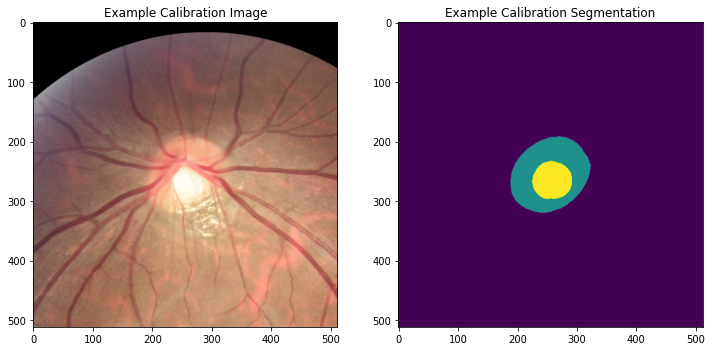

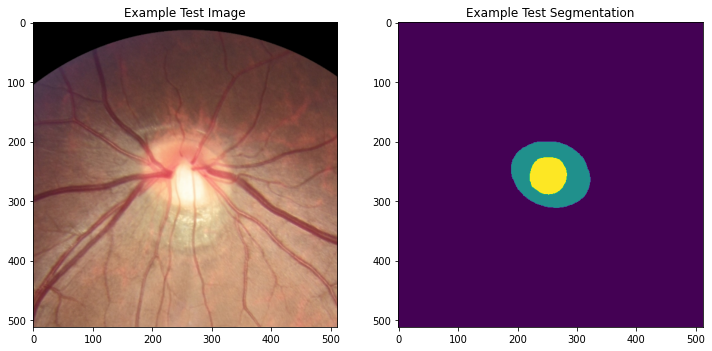

'\nAdd color bars!\n\n'

In [6]:
# Data Prep

## Calibration
cal_images_loader = load_images_with_dataloader(cal_images, 32, False)
cal_segs_loader = load_segs_with_dataloader(cal_segs, 32, False)

## Testing
test_images_loader = load_images_with_dataloader(test_images, 10, False)
test_segs_loader = load_segs_with_dataloader(test_segs, 10, False)

## Plotting Examples
cal_image_example = next(iter(cal_images_loader))[0].permute(1,2,0)
cal_seg_example = next(iter(cal_segs_loader))[0].permute(1,2,0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cal_image_example, cmap='gray')  # Image
axes[0].set_title('Example Calibration Image')

axes[1].imshow(cal_seg_example, cmap='viridis')  # Segmentation
axes[1].set_title('Example Calibration Segmentation')

plt.show()

## Plotting Examples
test_image_example = next(iter(test_images_loader))[0].permute(1,2,0)
test_seg_example = next(iter(test_segs_loader))[0].permute(1,2,0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(test_image_example, cmap='gray')  # Image
axes[0].set_title('Example Test Image')

axes[1].imshow(test_seg_example, cmap='viridis')  # Segmentation
axes[1].set_title('Example Test Segmentation')

plt.show()

'''
Add color bars!

'''

In [7]:
# Calibration organization and probabilities

X_cal = next(iter(cal_images_loader))
y_cal = next(iter(cal_segs_loader))
X_test = next(iter(test_images_loader))
y_test = next(iter(test_segs_loader))
cal_probs = model_prediction_segformer(model, cal_images_loader, 1)
test_probs = model_prediction_segformer(model, test_images_loader, 1)

print(f' X_cal shape: {X_cal.shape}, y_cal shape: {y_cal.shape}, cal_probs shape: {cal_probs.shape}, test_probs: {test_probs.shape}')

 X_cal shape: torch.Size([32, 3, 512, 512]), y_cal shape: torch.Size([32, 1, 512, 512]), cal_probs shape: torch.Size([32, 3, 512, 512]), test_probs: torch.Size([10, 3, 512, 512])


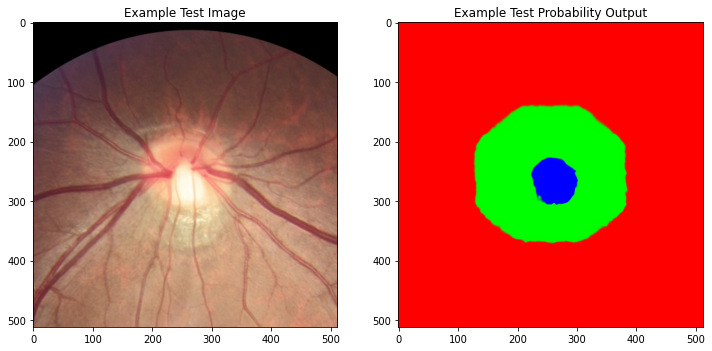

In [8]:
# Test Probabilities

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(test_image_example, cmap='gray')  # Image
axes[0].set_title('Example Test Image')

axes[1].imshow(test_probs[0].permute(1,2,0), cmap='viridis')  # Segmentation
axes[1].set_title('Example Test Probability Output')

plt.show()

### LAC

pred set shape: torch.Size([10, 3, 512, 512]), average per pixel per image: torch.Size([10, 512, 512]), average per image: torch.Size([10])
percent coverage across all pixels 0.998
Mean prediction set size across all pixels and test images: 0.4569999873638153


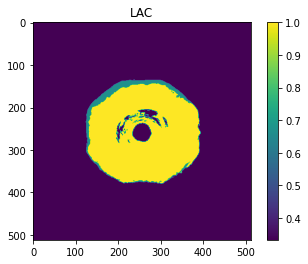

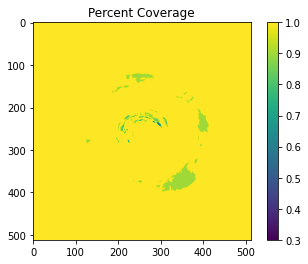

In [9]:
# Prediction sets

cal_scores = get_calibration_scores_lac(y_cal, cal_probs)
prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages = cuq_seg_pred_set_lac(cal_scores, 0.1, test_probs, y_test)

print(f'pred set shape: {prediction_sets.shape}, average per pixel per image: {average_per_pixel_per_image.shape}, average per image: {average_per_image.shape}')
print(f'percent coverage across all pixels {np.round(pct_coverages.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image.mean(), 3)}')

plt.imshow(average_per_pixel_per_image[0])
plt.title('LAC')
plt.colorbar()
plt.show()

plt.imshow(pct_coverages)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


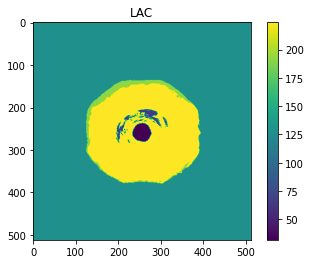

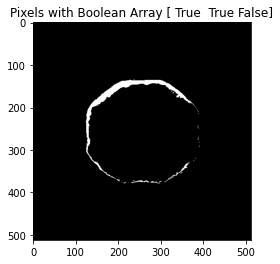

In [10]:
# Plotting

plot_classes(prediction_sets[0], 'LAC')

plot_specific_class(prediction_sets[0], np.array([True, True, False]))

### Top-K

pred set shape: torch.Size([10, 3, 512, 512]), average per pixel per image: (10, 512, 512), average per image: (10,)
Percent coverage across all pixels 0.995
Mean prediction set size across all pixels and test images: 0.424


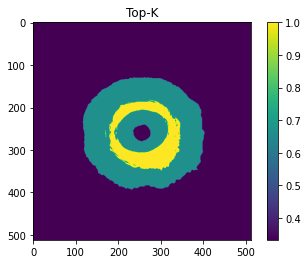

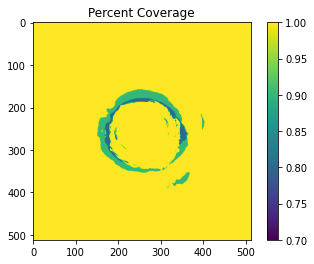

In [63]:
# Prediction sets

cal_scores, cal_pi = get_calibration_scores_topk(y_cal, cal_probs)
prediction_sets_topk, average_per_pixel_per_image, average_per_image, qhat_topk, pct_coverages, val_pi = cuq_seg_pred_set_topk(cal_scores, 0.1, test_probs, y_test)

print(f'Pred set shape: {prediction_sets.shape}, Average per pixel per image: {average_per_pixel_per_image.shape}, Average per image: {average_per_image.shape}')
print(f'Percent coverage across all pixels {np.round(pct_coverages.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image.mean(), 3)}')

plt.imshow(average_per_pixel_per_image[0])
plt.title('Top-K')
plt.colorbar()
plt.show()

plt.imshow(pct_coverages)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()


Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


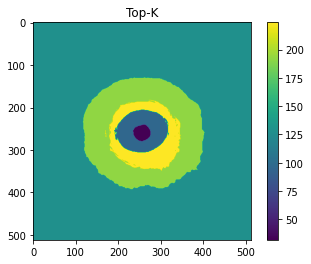

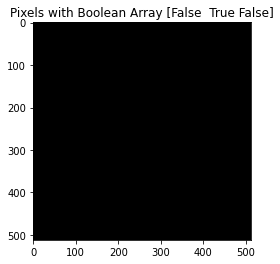

In [67]:
# Plotting

plot_classes(prediction_sets_topk[-1], 'Top-K')

plot_specific_class(prediction_sets_topk[-1], np.array([False, True, False]))

### APS

pred set shape: (10, 3, 512, 512), average per pixel per image: (10, 512, 512), average per image: (10,)
Percent coverage across all pixels 0.992
Mean prediction set size across all pixels and test images: 0.41


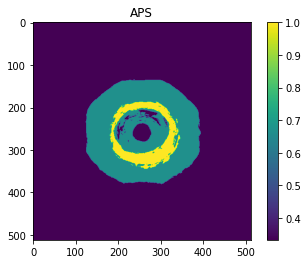

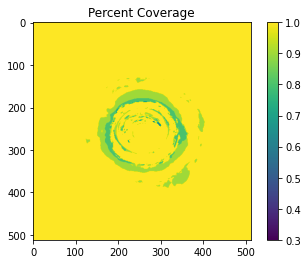

In [72]:
# Predictive Sets

cal_scores = get_calibration_scores_aps(y_cal, cal_probs)
prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages = cuq_seg_pred_set_aps(cal_scores, test_probs, 0.1, y_test)

print(f'pred set shape: {prediction_sets.shape}, average per pixel per image: {average_per_pixel_per_image.shape}, average per image: {average_per_image.shape}')
print(f'Percent coverage across all pixels {np.round(pct_coverages.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image.mean(), 3)}')

plt.imshow(average_per_pixel_per_image[0])
plt.title('APS')
plt.colorbar()
plt.show()

plt.imshow(pct_coverages)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


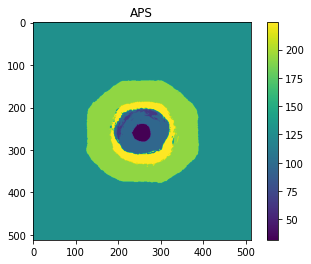

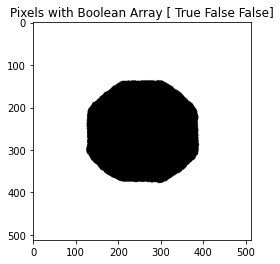

In [ ]:
# Plotting

plot_classes(prediction_sets[0], 'APS')

plot_specific_class(prediction_sets[0], np.array([False, False, True]))

### RAPS

pred set shape: (10, 3, 512, 512), average per pixel per image: (10, 512, 512), average per image: (10,)
Percent coverage across all pixels 0.995
Mean prediction set size across all pixels and test images: 0.439


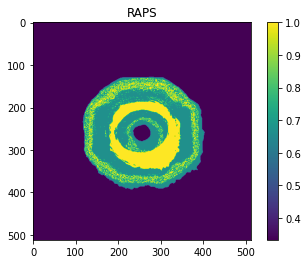

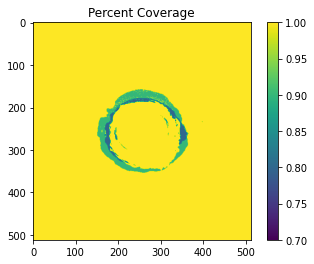

In [111]:
# Predictive Sets

lam_reg = 0.01
disallow_zero_sets = True
randomness = False
cal_scores, reg_vec_tensor = get_calibration_scores_raps(y_cal, cal_probs, lam_reg, qhat_topk)
prediction_sets, average_per_pixel_per_image, average_per_image, pct_coverages = cuq_seg_pred_set_raps(cal_scores, reg_vec_tensor, test_probs, disallow_zero_sets, randomness, 0.1, y_test)

print(f'pred set shape: {prediction_sets.shape}, average per pixel per image: {average_per_pixel_per_image.shape}, average per image: {average_per_image.shape}')
print(f'Percent coverage across all pixels {np.round(pct_coverages.mean(), 3)}')
print(f'Mean prediction set size across all pixels and test images: {np.round(average_per_image.mean(), 3)}')

plt.imshow(average_per_pixel_per_image[0])
plt.title('RAPS')
plt.colorbar()
plt.show()

plt.imshow(pct_coverages)
plt.title('Percent Coverage')
plt.colorbar()
plt.show()

Boolean Array: [False False False], Pixel Value: 0
Boolean Array: [False False  True], Pixel Value: 32
Boolean Array: [False  True False], Pixel Value: 64
Boolean Array: [False  True  True], Pixel Value: 96
Boolean Array: [ True False False], Pixel Value: 128
Boolean Array: [ True False  True], Pixel Value: 160
Boolean Array: [ True  True False], Pixel Value: 192
Boolean Array: [ True  True  True], Pixel Value: 224


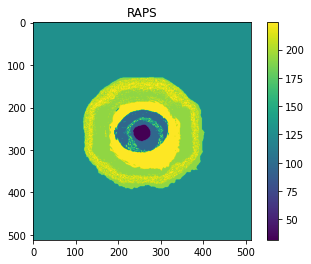

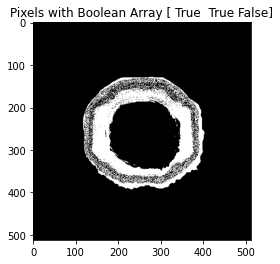

In [114]:
# Plotting

plot_classes(prediction_sets[0], 'RAPS')

plot_specific_class(prediction_sets[0], np.array([True, True, False]))

Note, if we are taking the average of a whole image, the size of the hard portion is going to throw off the calculation. As in, if there are a lot fo background points, the average will be lower, but not better. 

However, for a model with the *same* test sets, $\alpha$ ,etc., lower *will* be better.

We need to do alpha values versus emprical coverage.